In [17]:
# import packages
from sma import run_snscrape, sentiment, unsupervised
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
from datetime import datetime
import os
import gensim
from os import listdir
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.cluster import KMeans

Firstly we need to build our dataset on which we will perform our analysis. To do this I propose to use the SNScrape package which enables us to pull social content from a range of platforms, some with better access to posts than others. For example Meta owned platforms (Facebook, Instagram) tend to have greater restrictions on which data can be pulled through aggregators, while Twitter is fully exposed publicly and therefore returns higher qulity data when running the SNScrape functionality.

To simplify executiong of SNScrape functionality, I have created a simple wrapper function which validates the format of the arguments given, creates the API payload and passes it to the SNScrape excution function.

<u>A note on date ranges:</u>
It is worth noting that after significant testing i found that pulling large volumes of tweets in a single go can lead to excessive run times. This appears to result from the fact that the time taken to convert the response object - returned by snscrape - to a pandas dataframe increases drastically as the number of tweets returned increases. To avoid this, I suggest slicing your date range to smaller increments and iteratively pulling tweets for each - which is the approach I implement below

### Pull intial data

In [3]:
# define the terms and date range for which we wish to pull tweets
term = 'natwest'
timeframes = [
    ['2021-01-01', '2021-02-28'],
    ['2021-03-01', '2021-04-30'],
    ['2021-05-01', '2021-06-30'],
    ['2021-07-01', '2021-08-31'],
    ['2021-09-01', '2021-10-31'],
    ['2021-11-01', '2021-12-31']
]

In [ ]:
# pull tweets for each date range in turn
for timeframe in tqdm(timeframes):
    return_df = run_snscrape.scrape_twitter(term, date_range=timeframe, lang='en', limit=None)
    
    # save the output
    output_path = 'data/raw_{}_{}.pickle'.format(term, timeframe[0])
    return_df.to_pickle(output_path)

In [3]:
# consolidate files to create complete dataset
consolidated_df = pd.DataFrame()
for file in listdir('data'):
    if 'raw_{}'.format(term) in file:
        temp = pd.read_pickle('data/{}'.format(file))
        consolidated_df = pd.concat([consolidated_df, temp], axis=0)

#remove duplicate tweets
consolidated_df = consolidated_df.drop_duplicates(subset='content', ignore_index=True)

print(f'total tweet count: {len(consolidated_df)}')

# save a file format that we can view to manually explore the data
consolidated_df.to_csv(f'data/master_{term}.csv')
# save a version in a format that enables more efficient storage and loading
consolidated_df.to_pickle(f'data/master_{term}.pickle')

total tweet count: 76145


In [4]:
consolidated_df.head()

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,media,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags
0,https://twitter.com/adamwalton/status/13658135...,2021-02-27 23:58:31+00:00,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,1365813594533879811,"{'username': 'adamwalton', 'id': 12359262, 'di...",2,0,3,0,...,None,None,None,1.365813e+18,"{'username': 'peterdysart', 'id': 365487749, '...","[{'username': 'peterdysart', 'id': 365487749, ...",None,None,None,None
1,https://twitter.com/peterdysart/status/1365813...,2021-02-27 23:56:46+00:00,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,1365813155952271360,"{'username': 'peterdysart', 'id': 365487749, '...",1,0,1,0,...,None,None,None,1.365813e+18,"{'username': 'adamwalton', 'id': 12359262, 'di...","[{'username': 'adamwalton', 'id': 12359262, 'd...",None,None,None,None
2,https://twitter.com/AppianCTO/status/136581291...,2021-02-27 23:55:49+00:00,Digital banking - NatWest and HSBC “focus on a...,Digital banking - NatWest and HSBC “focus on a...,1365812914716872706,"{'username': 'AppianCTO', 'id': 211968345, 'di...",0,1,1,0,...,None,None,None,NaN,None,None,None,None,"[lowcode, automation, process]",None
3,https://twitter.com/adamwalton/status/13658128...,2021-02-27 23:55:43+00:00,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,1365812889924362241,"{'username': 'adamwalton', 'id': 12359262, 'di...",3,0,2,0,...,None,None,None,1.365811e+18,"{'username': 'cakeypigdonkey', 'id': 91802436,...","[{'username': 'cakeypigdonkey', 'id': 91802436...",None,None,None,None
4,https://twitter.com/cakeypigdonkey/status/1365...,2021-02-27 23:47:45+00:00,@tomwm1984 @adamwalton @TheRotanas Many years ...,@tomwm1984 @adamwalton @TheRotanas Many years ...,1365810884677935118,"{'username': 'cakeypigdonkey', 'id': 91802436,...",1,0,2,0,...,None,None,None,1.365809e+18,"{'username': 'tomwm1984', 'id': 362341111, 'di...","[{'username': 'tomwm1984', 'id': 362341111, 'd...",None,None,None,None


### Tag sentiment

Next we will tag all the posts to understand the sentiment. For social media text we will use VADER model which is specifically built on social content and therefore can account for things such as emojis and slang. Furthermore the fact it is a taxonomy based approach means we avoid the need to long compute times as well as being able to return polarity scores which can shed greater insight - such as not just whether a tweet is negative, but the degree to which it is negative

In [9]:
master_df = pd.read_pickle(f'data/master_{term}.pickle')

# we will use Vader for sentiment, and return the full polarity output
tqdm.pandas()
new_cols = ['sent_positive', 'sent_negative', 'sent_neutral', 'sent_compound', 'sentiment']
master_df[new_cols] = master_df.progress_apply(lambda x: sentiment.vader_sentiment(x['content'], return_polarities=True), axis=1, result_type='expand')

# save file
master_df.to_pickle(f'data/sentiment_{term}.pickle')
master_df.to_csv(f'data/sentiment_{term}.csv')

100%|██████████| 76145/76145 [05:55<00:00, 214.01it/s]


In [4]:
master_df = pd.read_pickle(f'data/sentiment_{term}.pickle')
master_df.head()

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,mentionedUsers,coordinates,place,hashtags,cashtags,sent_positive,sent_negative,sent_neutral,sent_compound,sentiment
0,https://twitter.com/adamwalton/status/13658135...,2021-02-27 23:58:31+00:00,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,1365813594533879811,"{'username': 'adamwalton', 'id': 12359262, 'di...",2,0,3,0,...,"[{'username': 'peterdysart', 'id': 365487749, ...",None,None,None,None,0.089,0.074,0.837,0.1531,Positive
1,https://twitter.com/peterdysart/status/1365813...,2021-02-27 23:56:46+00:00,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,1365813155952271360,"{'username': 'peterdysart', 'id': 365487749, '...",1,0,1,0,...,"[{'username': 'adamwalton', 'id': 12359262, 'd...",None,None,None,None,0.000,0.000,1.000,0.0000,Neutral
2,https://twitter.com/AppianCTO/status/136581291...,2021-02-27 23:55:49+00:00,Digital banking - NatWest and HSBC “focus on a...,Digital banking - NatWest and HSBC “focus on a...,1365812914716872706,"{'username': 'AppianCTO', 'id': 211968345, 'di...",0,1,1,0,...,None,None,None,"[lowcode, automation, process]",None,0.000,0.000,1.000,0.0000,Neutral
3,https://twitter.com/adamwalton/status/13658128...,2021-02-27 23:55:43+00:00,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,1365812889924362241,"{'username': 'adamwalton', 'id': 12359262, 'di...",3,0,2,0,...,"[{'username': 'cakeypigdonkey', 'id': 91802436...",None,None,None,None,0.000,0.144,0.856,-0.6908,Negative
4,https://twitter.com/cakeypigdonkey/status/1365...,2021-02-27 23:47:45+00:00,@tomwm1984 @adamwalton @TheRotanas Many years ...,@tomwm1984 @adamwalton @TheRotanas Many years ...,1365810884677935118,"{'username': 'cakeypigdonkey', 'id': 91802436,...",1,0,2,0,...,"[{'username': 'tomwm1984', 'id': 362341111, 'd...",None,None,None,None,0.061,0.075,0.865,-0.1511,Negative


Now that we have tagged sentiment, we can plot our dataset to display the number of tweets over time, and indeed the volume of each sentiment to see if any interesting patterns or spikes emerge

In [5]:
# add a new numeric column, populated with '1', which we will plot to show the number of tweets in a given day
master_df['count'] = 1

# now we can add three binary colums to indicate whether the sentiment for each tweet is positve, negative, or neutral
# note: to retain the categorical sentiment column it helps to duplicate before breaking out to binary
master_df['temp_sentiment'] = master_df['sentiment']
master_df = pd.get_dummies(master_df, columns=['sentiment'])
master_df = master_df.rename(columns = {'temp_sentiment': 'sentiment'})

# next we will create a new Date column where we will group the datetime in our data to each distinct date
master_df['Date'] =  pd.to_datetime(master_df['date']).dt.date

master_df.head()

,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,sent_positive,sent_negative,sent_neutral,sent_compound,count,sentiment,sentiment_Negative,sentiment_Neutral,sentiment_Positive,Date
0,https://twitter.com/adamwalton/status/13658135...,2021-02-27 23:58:31+00:00,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,@peterdysart @cakeypigdonkey @tomwm1984 @TheRo...,1365813594533879811,"{'username': 'adamwalton', 'id': 12359262, 'di...",2,0,3,0,...,0.089,0.074,0.837,0.1531,1,Positive,0,0,1,2021-02-27
1,https://twitter.com/peterdysart/status/1365813...,2021-02-27 23:56:46+00:00,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,@adamwalton @cakeypigdonkey @tomwm1984 @TheRot...,1365813155952271360,"{'username': 'peterdysart', 'id': 365487749, '...",1,0,1,0,...,0.000,0.000,1.000,0.0000,1,Neutral,0,1,0,2021-02-27
2,https://twitter.com/AppianCTO/status/136581291...,2021-02-27 23:55:49+00:00,Digital banking - NatWest and HSBC “focus on a...,Digital banking - NatWest and HSBC “focus on a...,1365812914716872706,"{'username': 'AppianCTO', 'id': 211968345, 'di...",0,1,1,0,...,0.000,0.000,1.000,0.0000,1,Neutral,0,1,0,2021-02-27
3,https://twitter.com/adamwalton/status/13658128...,2021-02-27 23:55:43+00:00,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,@cakeypigdonkey @tomwm1984 @TheRotanas @NatWes...,1365812889924362241,"{'username': 'adamwalton', 'id': 12359262, 'di...",3,0,2,0,...,0.000,0.144,0.856,-0.6908,1,Negative,1,0,0,2021-02-27
4,https://twitter.com/cakeypigdonkey/status/1365...,2021-02-27 23:47:45+00:00,@tomwm1984 @adamwalton @TheRotanas Many years ...,@tomwm1984 @adamwalton @TheRotanas Many years ...,1365810884677935118,"{'username': 'cakeypigdonkey', 'id': 91802436,...",1,0,2,0,...,0.061,0.075,0.865,-0.1511,1,Negative,1,0,0,2021-02-27


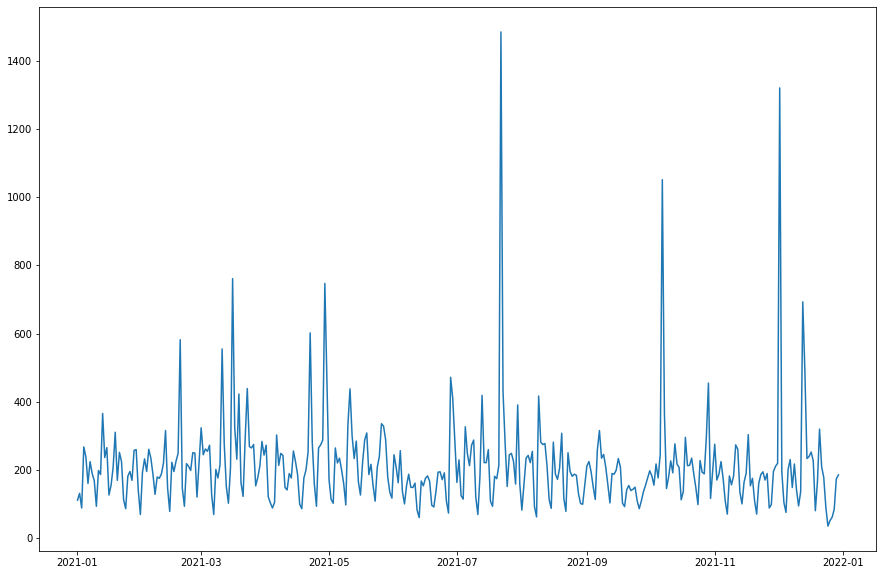

In [6]:
count_df = master_df.groupby('Date')['count'].sum()

plt.figure(figsize=(15,10))
plt.plot(count_df)

While this first view gives us a plot of the number of tweets (and retweets) per day, the plot is extremely messy and volatile - with sharp spikes.

While this view may be interesting to identify individual explosions in conversation, it is going to become almost impossible to extract meaningful insight when we come to observing the proportion of comments by sentiment. To overcome this, we can aggregate to a weekly level and observe the patterns

In [7]:
# next we will create a new Date column where we will group the datetime in our data to each distinct date
master_df['Year'] =  pd.to_datetime(master_df['Date']).dt.year
master_df['Month'] =  pd.to_datetime(master_df['Date']).dt.month
master_df['Week'] =  pd.to_datetime(master_df['Date']).dt.week

# if we were to aggregate by week, and had multiple years worth of data, we risk grouping comments across years
# despite only dealing with one year of data in this example, it is important to apply best practices
# so we will create a new column that provides the start date of each week (based on Year - Week) and aggregate to this 
master_df['Year-Week'] = pd.to_datetime(master_df['Year'].astype(str) + ' ' + master_df['Week'].astype(str) + ' 1', format='%Y %U %w').dt.date
# Note the addition of " 1" at the end indicates Monday week start (" 0" can be used for Sunday to Sunday)

master_df.sample(5)

C:\Users\fergu\AppData\Local\Temp\ipykernel_25436\3342535088.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  master_df['Week'] =  pd.to_datetime(master_df['Date']).dt.week


,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,count,sentiment,sentiment_Negative,sentiment_Neutral,sentiment_Positive,Date,Year,Month,Week,Year-Week
53645,https://twitter.com/edcumming/status/145148687...,2021-10-22 09:53:32+00:00,NatWest determined to induce a stroke https://...,NatWest determined to induce a stroke https://...,1451486874086805520,"{'username': 'edcumming', 'id': 18996798, 'dis...",5,1,9,0,...,1,Positive,0,0,1,2021-10-22,2021,10,42,2021-10-18
119,https://twitter.com/benorkevup2u/status/136556...,2021-02-27 07:36:29+00:00,"@LloydsBank Hello Colin, thanks for reaching o...","@LloydsBank Hello Colin, thanks for reaching o...",1365566457665511426,"{'username': 'benorkevup2u', 'id': 635573175, ...",1,0,0,0,...,1,Positive,0,0,1,2021-02-27,2021,2,8,2021-02-22
18942,https://twitter.com/LizoSpoons/status/13762058...,2021-03-28 16:13:40+00:00,@BenjiRadkovic @qikipedia I'm almost sure I wo...,@BenjiRadkovic @qikipedia I'm almost sure I wo...,1376205861979308037,"{'username': 'LizoSpoons', 'id': 9876673218157...",0,0,0,0,...,1,Positive,0,0,1,2021-03-28,2021,3,12,2021-03-22
33222,https://twitter.com/andypritchard09/status/139...,2021-05-22 19:17:06+00:00,@NatWest_Help do you have online chat as I ha...,@NatWest_Help do you have online chat as I ha...,1396183354182098955,"{'username': 'andypritchard09', 'id': 25392315...",1,0,0,0,...,1,Negative,1,0,0,2021-05-22,2021,5,20,2021-05-17
50123,https://twitter.com/NatWest_Help/status/141318...,2021-07-08 17:23:57+00:00,@siphoxolo1 Hiya! We'd be happy to assist - if...,@siphoxolo1 Hiya! We'd be happy to assist - if...,1413187110417444871,"{'username': 'NatWest_Help', 'id': 284540385, ...",0,0,1,0,...,1,Positive,0,0,1,2021-07-08,2021,7,27,2021-07-05


C:\Users\fergu\AppData\Local\Temp\ipykernel_25436\2623798070.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  agg_df = master_df.groupby(['Year-Week'])['count', 'sentiment_Negative', 'sentiment_Positive', 'sentiment_Neutral'].sum()


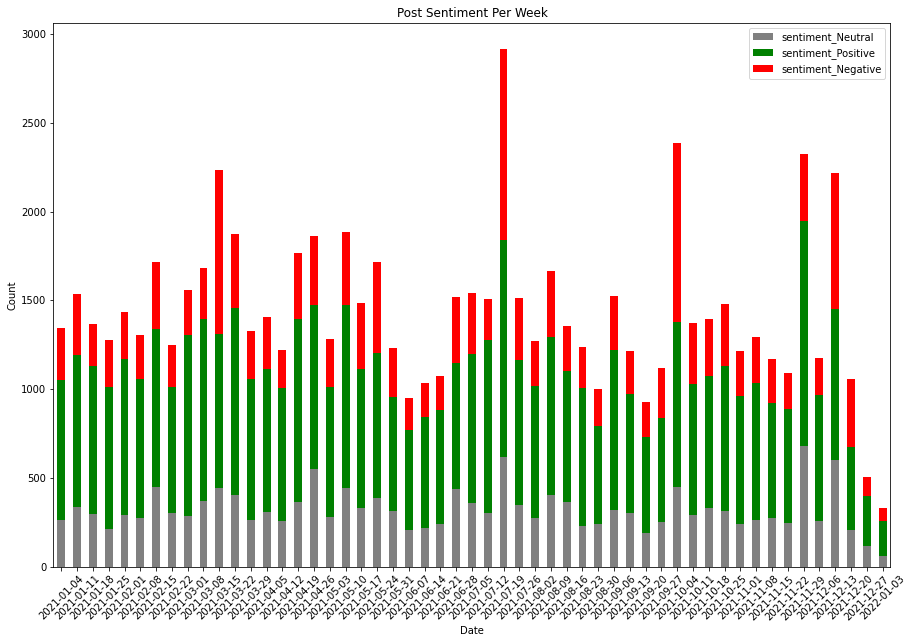

In [8]:
# create a new table by aggregating the post counts to a weekly level
agg_df = master_df.groupby(['Year-Week'])['count', 'sentiment_Negative', 'sentiment_Positive', 'sentiment_Neutral'].sum()

# plot the stacked bar chart to show frequency of posts by sentiment
agg_df[['sentiment_Neutral', 'sentiment_Positive', 'sentiment_Negative']].plot.bar(
    stacked=True, color = ['grey', 'green', 'red'], width=0.5, figsize=(15,10))

plt.xticks(rotation = 45)
plt.title('Post Sentiment Per Week')
plt.ylabel('Count')
plt.xlabel('Date')

plt.show()


### Unsupervised clustering

To build out more detailed insights on our data it will be necessary to tag our tweets with a wider range of topics, to understand the content that users are posting about. This could be achieved by training a supervised model on a pre-determine training set, where a corpus of text documents/snippets have already been tagged to topics of interest. However, for the purpose of this project we will look to build out our own training data - through leveraging unsupervised clustering.

For this we will leverage Kmeans clustering to group tweets, based on the Euclidean distance of their text embeddings - i.e. how close together tweets are in the types of words they discuss

As we are only interested in new topic people are discussing, we will leverage only original tweets, not retweets or replies

In [9]:
tweets_df = master_df[(master_df['inReplyToTweetId'].isna()) & (master_df['retweetedTweet'].isna())].reset_index(drop=True)
print('There are ', str(len(tweets_df)), ' original tweets')

There are  34469  original tweets


Now comes the clustering, which we will perform by first embedding the tweets (converting them to a vector format that represents the text in multi-dimensional numeric format), and an unsupervised clustering algorithm which looks to group tweets based on how similar (close together) their word embeddings are.

For the embedding, much literature (e.g. "Text Document Clustering: Wordnet vs. TF-IDF vs. Word Embeddings", Marcinczuk et al & "An Empirical Survey of Unsupervised Text Representation Methods on Twitter Data", Wang et al) would suggest that more advanced embedding techniques - such as BERT - do not necessarily perform better than more traditional wordnet or term frequency models. This is likely because transformers models such as BERT are specifically trained based on encoder-decoder architecture whereby the embeddings (output from the encoder part of the architecture) are abstract, with little meaning outwith the task that they were specifically tuned for. Therefore, it is likely that custom training is required on your dataset in order to extract meaningful embeddings from such models.

However, tuning such large transformers models can require a great deal of GPU and time. With this in mind, we will opt for a more traditional modelling approach for generating our embeddings

In [15]:
# perform preprocessing to clean the tweet to the core components for clustering
tqdm.pandas()
tweets_df['cleaned_tweet'] = tweets_df['content'].progress_apply(lambda x: unsupervised.clean_tweet(x))

# drop duplicates
tweets_df = tweets_df.drop_duplicates(subset=['cleaned_tweet'], inplace=False).reset_index(drop=True)

# keep just the text and cleaned columns (all that is required for us to build our training data)
tweets_df = tweets_df[['content', 'cleaned_tweet']]

# save the cleaned dataframe
tweets_df.to_pickle(f'data/cleaned_unsupervised_{term}.pickle')

100%|██████████| 34469/34469 [02:26<00:00, 234.84it/s]


Now that we have our cleaned tweets we can embed them. While TFIDF can be effective in identifying themes, based purely on the frequency and importance of key words, I am interested in using a slightly more sophisticated method which at least learns some relationships between words. Therefore something like Word2Vec would offer a good option. We will use the Gensim package to access word2vec model architecture

We can train our Word2Vec model byt passing it our corpus of words, which it uses to create a multi-dimensional vector space, into which it places each word (assigning it a vector to decribe its position in the vector space), with similar words near to one another. Moreover, these vectors help to describe semantic relationships between words, such that "King (vector) - Man (vector) + Woman (vector)" would in theory provide a vector that closely describes the word Queen.

We can then obtian a vector to describe each of our tweets by aggregating the vectors for each word in the text - for short text (as in the case of tweets) averaging the vectors tends to provide good results.

In [10]:
# read back in the data if necessary (i.e. as a checkpoint)
tweets_df = pd.read_pickle(f'data/cleaned_unsupervised_{term}.pickle')

# train our word2vec model
tweets_df['tokens'] = tweets_df['cleaned_tweet'].apply(lambda x: word_tokenize(x))
w2v_model = Word2Vec(tweets_df['tokens'], vector_size=120, window=5, min_count=2, workers=4, sg=0, seed=1)

# note: 'seed' set the initial vectors that Word2Vec randomly initiates with
# however, you will still get slightly different results if spreading processing over multiple workers
# in order to get completely repeatable results you'd need to set 'workers = 1' for avoid thread jittering

Now we have trained the model on our data we can test to see if the results make sense. one way to do this is by passing the model a word and seeing what other words it has learned as being similar  - i.e. appear in a similar semantic context

In [12]:
# test outputs by extracting similar words
w2v_model.wv.most_similar("card")

[('direct', 0.9475381374359131),
 ('visa', 0.8996523022651672),
 ('cancel', 0.8951806426048279),
 ('debit', 0.8863329887390137),
 ('order', 0.8790035843849182),
 ('pin', 0.8710721135139465),
 ('sometimes', 0.8648321628570557),
 ('clone', 0.8627472519874573),
 ('contactless', 0.861782431602478),
 ('refund', 0.8602686524391174)]

In [14]:
# create the average vector for each tweet
tqdm.pandas()
tweets_df['embedding'] = tweets_df['tokens'].progress_apply(lambda x: unsupervised.obtain_tweet_vector(x, w2v_model))

# drop tweets where the vector is Null - as words not in Word2Vec vocab
tweets_df = tweets_df[~tweets_df['embedding'].isnull()]

# create an input array to feed into KMeans clustering from our vector embeddings column
vectors_array = np.array(list(tweets_df['embedding']))

  0%|          | 0/29457 [00:00<?, ?it/s]c:\Users\fergu\Documents\PersonalProjects\Social_Analytics\venv\lib\site-packages\sma\unsupervised.py:65: RuntimeWarning: Mean of empty slice.
  average_vector = np.asarray(vectors).mean(axis=0)
100%|██████████| 29457/29457 [00:00<00:00, 33903.59it/s]


The number of clusters we will group our data into can be determined by plotting an "elbow plot". This is achieved by iterating through a definined number of clusters and running kmeans for each, then computing the "distortions" (i.e. the sum of the squared distances from each point to the centroid of its assigned cluster). In effect it looks for how well clustered each goruping is.

We can observe this too find the optimum number of clusters - that is the number whereby we obtain a low enough average distance, and above which increasing the number of clusters leads to relatively lower improvement in spread

Computing distortions 1 / 20
Computing distortions 2 / 20
Computing distortions 3 / 20
Computing distortions 4 / 20
Computing distortions 5 / 20
Computing distortions 6 / 20
Computing distortions 7 / 20
Computing distortions 8 / 20
Computing distortions 9 / 20
Computing distortions 10 / 20
Computing distortions 11 / 20
Computing distortions 12 / 20
Computing distortions 13 / 20
Computing distortions 14 / 20
Computing distortions 15 / 20
Computing distortions 16 / 20
Computing distortions 17 / 20
Computing distortions 18 / 20
Computing distortions 19 / 20


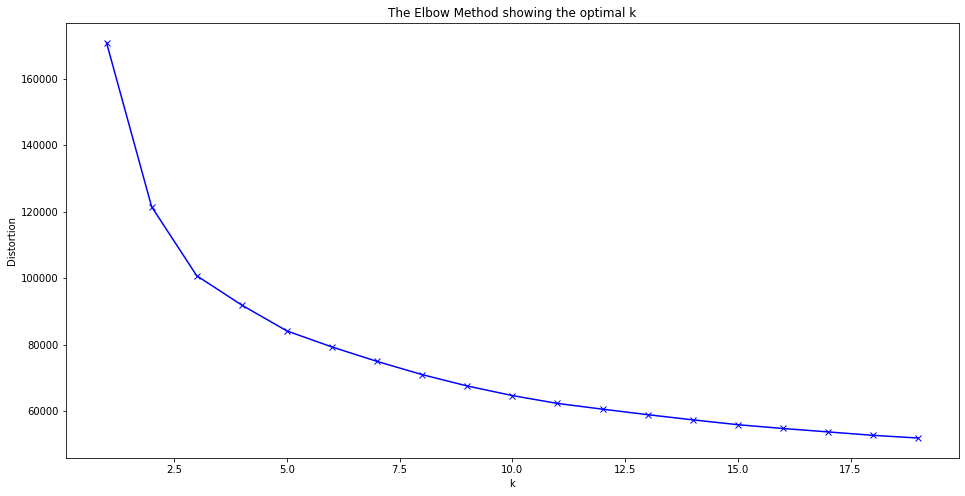

In [15]:
# plot elbow curve
unsupervised.plot_elbow(vectors_array, max_clusters=20)

From the above plot we can see that as the number of clusters increases the average spread of the clusters (the average distance squared of each point to the centroid) decreases. This indicates that the clusters formed become more consistent as the number increases - which intuitive makes sense.

However, past a certain point increasing the numbers of clusters does not result in significantly lower spread. For the sake of this example we will take 10 clusters as it is offers us decent enough spread (for this example) and is a manageable number of analyse manually - which we'll come to below.

In [18]:
# run clustering on dataset using preferred cluster number
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(vectors_array)

# extract the cluster numbers from the trained model
tweets_df['cluster'] = kmeans.labels_

# save the output for manual investigation
tweets_df[['content', 'cleaned_tweet', 'cluster']].to_csv(f'data/clustered_unsupervised_{term}.csv')

We can now go ahead and manually explore the clusters we have to determine what topics or themes each is discussing. From observing the types of comments that we see in each cluster we can begin to build up a view of what each cluster is about, and record this in a matrix to use for later

In [ ]:
cluster_themes = {
    0: 'request for account and card advice/help',
    1: 'generic - noisey',
    2: 'generic - noisey',
    3: 'stance on cryptocurencies',
    4: 'generic - noisey',
    5: 'issues with mobile app and online',
    6: 'sports event sponsorship',
    7: 'generic banking news',
    8: 'workshops, conferences and partnerships',
    9: 'regulatory issues'
}

In [77]:
sample = tweets_df.sample(1000)